# Boosting for Regression on UCI Concrete Compressive Strength Dataset 
 - Anyesha Ghosh(ag64774) & Madhumitha Sakthi(ms75986)

We have done three boosting algorithms for Linear Regression. 
Each of the weak learners are trained on Concrete Dataset by randomly selecting 2 features among 8 (Total number of features).

1. Gradient Boosting$^{[1]}$, 2. Frank-Wolfe Boosting$^{[2]}$ , 3. AdaBoost Regressor$^{[3]}$

#### Base Learner used:
All these algorithms use the same base learner ; Linear Regressor for Adaboost Regressor & FW Regressor , Gradient Boosting.
The strength of the base learner is is controlled by limiting the number of input features which were provided to the regressor. 
#### Loss functions & descent algorithms:
- Adaboost Regressor: The first & most widely used algorithm for boosting Regression ensembles. We have implemented AdaBoost.R2 which the standard regressor used. In each iteration, the weak learners try to minimize the loss function $L = \sum{||y_{i}-f_{i}(t)||}$. As shown in $^{[1]}$, Adaboost.R2 does a simple gradient descent.

- Gradient Boosting: Like other boosting methods, gradient boosting combines weak "learners" into a single strong learner in an iterative fashion. In the least-squares regression setting, where the goal is to "teach" a model $F$ to predict values in the form $\hat{y} = F(x) $ by minimizing the mean squared error ${({\hat {y}}-y)^{2}}$, averaged over some training set of actual values of the output variable  $y$.

- Frank-Wolfe boost: Uses the same loss function as the other two, but uses the Frank-Wolfe algorithm to perform each gradient descent step.
As we can see, we have implemented all the algorithms with a "vanilla" version of the squared loss function, and not included any regularization terms.

#### Metrics used for comparison:
In this project, we compare our algorithms on the following metrics: 
- Test & training error w.r.t. the number of iterations.
- Test & training error w.r.t. the time taken by the algorithm.
- Overfitting behaviour w.r.t. the complexity of the base Regressor.
- Robustness (simulated by adding randomly sampled N(0,1) error to the label.

#### Dataset description:
The UCI Concerete Compression Strength Dataset has 1030 data points, each with 9 features,8 quantative input variables and 1 quantative output variable. We divided the dataset into two parts - the last 370 datapoints constitute the test set, and the remaining constitute the training set. We did not use any cross validation techniques for this project.


Reference: 

[1]Mason L., Baxter J., Bartlett P., Frean M., Boosting algorithms as gradient descent, 12th International Conference on Neural Information Processing Systems, 1999


[2]Wang C.,Wang L., et al., Functional Frank-Wolfe Boosting for General Loss Functions, arXiv:1510.02558(stat.ML), 2015


[3] D.P. Solomatine ; D.L. Shrestha, AdaBoost.RT: a boosting algorithm for regression problems, 10.1109/IJCNN.2004.1380102, 2004


In [1]:
import sys
sys.path.append("/Users/vasanti/miniconda2/lib/python2.7/site-packages")
%matplotlib inline
import numpy as np
from os import getcwd
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
from numpy.linalg import inv
import random
import math
import csv
from time import clock
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
import pandas as pd

In [2]:
file = r'Concrete_Data.xls'
df = pd.read_excel(file)
Y = df.as_matrix()
X_train = Y[0:720,0:8]
Y_train = Y[0:720,8]
X_test = Y[719:1029,0:8]
Y_test = Y[719:1029,8]

In [3]:
""" HELPER FUNCTION: PRINT ERROR RATE ======================================="""
def print_error_rate(err):
    print 'Error rate: Training: %.4f - Test: %.4f' % err

In [4]:
""" HELPER FUNCTION: GET ERROR RATE ========================================="""
def get_error_rate(pred, Y):
    return la.norm((pred - Y),2)/len(Y) 

In [5]:
""" HELPER FUNCTION: GENERIC CLASSIFIER ====================================="""
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train),get_error_rate(pred_test, Y_test)
    

In [6]:
""" GRADIENT BOOSTING IMPLEMENTATION ================================================="""
def Gradient_boost(Y_train, X_train, Y_test, X_test, M, fnum,an, clf):
    n_train, n_test = len(X_train), len(X_test)
    
    pred_train = np.zeros(n_train)
    pred_test = np.zeros(n_test)
    err_train = np.zeros(M)
    err_test = np.zeros(M)
    time_taken = np.zeros(M)
    start_time = clock()
    if an ==1 : 
        Y_train_noise = Y_train + rn.normal(np.average(Y_train),5,n_train)
    
    
    for i in range(M):        
        X = rn.permutation(8)
        X_train_1 = X_train[:,X[0:fnum]]
        X_test_1 = X_test[:,X[0:fnum]]
        
        if an==1 : 
            r = -2*(pred_train - Y_train_noise)
        else: 
            r = -2*(pred_train - Y_train)
        clf.fit(X_train_1, r)        
        pred_train_i = clf.predict(X_train_1)
        pred_test_i = clf.predict(X_test_1)        
        rho_t = np.dot((pred_train - Y_train),pred_train_i)/la.norm(pred_train_i,2)
        #Add to prediction
        pred_train = pred_train + (0.01*pred_train_i)
        pred_test = pred_test + (0.01*pred_test_i)
        
        # Update error series.
        err_train[i] =  get_error_rate((pred_train),Y_train)
        err_test[i] = get_error_rate((pred_test),Y_test)        
        # Update time series.
        time_taken[i] = clock() - start_time

    return pred_train,pred_test,err_train,err_test,time_taken

In [7]:
""" FRANK WOLFE IMPLEMENTATION ================================================="""
def fwboost_1_clf(Y_train, X_train, Y_test, X_test, M, fnum, an, clf):
    n_train, n_test = len(X_train), len(X_test)
    pred_train = np.zeros(n_train)
    pred_test = np.zeros(n_test)
    err_train = np.zeros(M)
    err_test = np.zeros(M)
    time_taken = np.zeros(M)
    C = 20
    
    if an ==1 : 
        Y_train_noise = Y_train + rn.normal(np.average(Y_train),5,n_train)
        
    start_time = clock()
    for i in range(M):
        X = rn.permutation(8)
        X_train_1 = X_train[:,X[0:fnum]]
        X_test_1 = X_test[:,X[0:fnum]]
        
        if an ==1 : 
            r = -(pred_train - Y_train_noise)*2  
        else:             
            r = -(pred_train - Y_train)*2  


        clf.fit(X_train_1, r)        
        #print clf.coef_
        #h*
        pred_train_i = clf.predict(X_train_1)
        pred_test_i = clf.predict(X_test_1)        
        gamma = 2/(i+0.25)        
        #Add to prediction
        pred_train = (1-gamma)*pred_train + (gamma*C*pred_train_i)/max(pred_train_i)
        pred_test = (1-gamma)*pred_test + (gamma*C*pred_test_i)/max(pred_train_i)
        err_train[i] =  get_error_rate((pred_train),Y_train)
        err_test[i] = get_error_rate((pred_test),Y_test)        
        # Update time series.
        time_taken[i] = clock() - start_time

    return pred_train,pred_test,err_train,err_test,time_taken

In [8]:
""" ADABOOST IMPLEMENTATION ================================================="""
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, fnum, an, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train = np.zeros(n_train)
    pred_test = np.zeros(n_test)
    err_train = np.zeros(M)
    err_test = np.zeros(M)
    time_taken = np.zeros(M)
    #pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    phi = 0
    start_time = clock()
    if an ==1 : 
        Y_train_noise = Y_train + rn.normal(np.average(Y_train),5,n_train)
    
    
    for i in range(M):
        # Fit a classifier with the specific weights
        
        X = rn.permutation(8)
        X_train_1 = X_train[:,X[0:fnum]]
        X_test_1 = X_test[:,X[0:fnum]]
        
        if an ==1 : 
            clf.fit(X_train_1, Y_train_noise, sample_weight = w)
        else: 
            clf.fit(X_train_1, Y_train, sample_weight = w)


         
        pred_train_i = clf.predict(X_train_1)
        pred_test_i = clf.predict(X_test_1)   
        
        it = abs(pred_train_i-Y_train)
        it = it/max(it)
        #it = it/n_train
        it = np.power(it,2)
        
        err = sum(w*it)/n_train
        #err = sum(w*it)
        beta = err/(1-err)
        
        w = w*np.power(beta,1-it)
        w = w/la.norm(w)
        #print err
        # Add to prediction
        phi = phi - np.log(beta)
        pred_train = pred_train -np.log(beta)*pred_train_i
        pred_test = pred_test -np.log(beta)*pred_test_i
        # Update error series.
        err_train[i] =  get_error_rate((pred_train)/phi,Y_train)
        err_test[i] = get_error_rate((pred_test)/phi,Y_test)
        # Update time series.
        time_taken[i] = clock() - start_time
        
    return pred_train,pred_test,err_train,err_test,time_taken

In [9]:
""" PLOT FUNCTION ==========================================================="""
#xseries is a numpy array, passed as a parameter when we are plotting w.r.t.
#anything other than number of iterations.
def plot_1_clf(er_train, er_test, xlabel, ylabel, name, p, xseries=[]):
    if len(xseries) != 0:
        plt.plot(xseries,er_train)
        plt.plot(xseries,er_test)
    else:
        plt.plot(er_train)
        plt.plot(er_test)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if p == 1:
        plt.legend(['Without Noise','With Noise'])
    else: 
        plt.legend(['Training data','Test data'])


    plt.title(ylabel + ' for ' + name)
    plt.show()

In [10]:
""" PLOT FUNCTION ==========================================================="""
#names is a list of strings providing the legend.
def plot_clf_series(series,names,xlabel,ylabel,p,xseries = []):
    M = series.shape[1]
    for i in range(M):
        if len(xseries) != 0:
            plt.plot(xseries[:,i],series[:,i])
        else:
            plt.plot(series[:,i])
    plt.legend(names)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

Below, we run each of the algorithms for 300 iterations. All the algorithms use a decision stump as the base Regressor. This enables us to judge the fitting accuracy and the overfitting behaviour of our algorithms.

In [11]:
# Fix the number of algorithms that are being implemented.
NUM_ALGO = 3
#List the algorithm names.
names = ['Adaboost Regressor','Frank-Wolfe Boosting','Gradient Boosting']

In [12]:
# Seeing the effect of changing the number of iterations. 
#Set number of iterations.
N = 300
#Initialize the arrays.
er_train_0 = np.zeros([N,NUM_ALGO])
er_test_0 = np.zeros([N,NUM_ALGO])
time_taken_0 = np.zeros([N,NUM_ALGO])
fnum =2
#Iterate over the algorithms.
an = 0
#Adaboost
clf_base = LinearRegression()
pred_train,pred_test,er_train_0[:,0],er_test_0[:,0],time_taken_0[:,0] = adaboost_clf(Y_train, X_train, Y_test, X_test, N, 1, an, clf_base)

# fw boosting
clf_base = LinearRegression()
pred_train,pred_test,er_train_0[:,1],er_test_0[:,1],time_taken_0[:,1] = fwboost_1_clf(Y_train, X_train, Y_test, X_test, N, fnum, an, clf_base)

clf_base = LinearRegression()
pred_train,pred_test,er_train_0[:,2],er_test_0[:,2],time_taken_0[:,2] = Gradient_boost(Y_train, X_train, Y_test, X_test, N, fnum,an, clf_base)


In the two cells below, we plot the Loss function for each of our algorithms. Specifically, we notice the following things.
- As expected, Adaboost is not very resistant to overfitting w.r.t. the number of iterations. The other two algorithms are more resistant to overfitting.
- We also notice that FW boost reaches lowest training loss very quickly (in ~20 iterations), and Adaboost takes significantly longer (~100 iterations). Meanwhile, Gradient boosting reach a very low training error at a later stage.
- The final training & test losses for Adaboost and FW boost are very similar, and the lowest loss is achieved by Gradient boosting. 

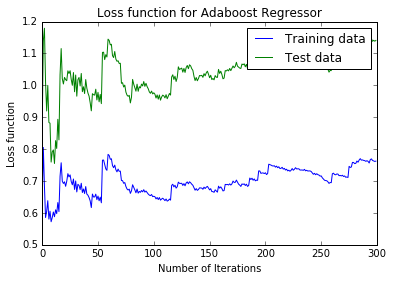

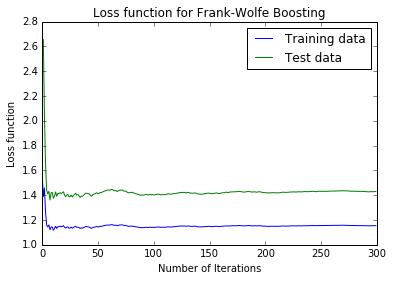

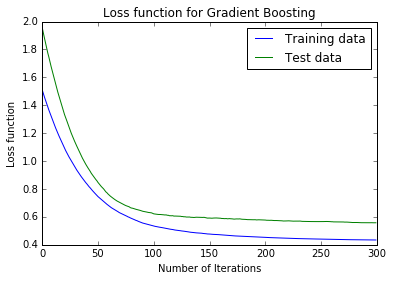

In [13]:
#Plot training and test errors for each algorithm.
for i in range(NUM_ALGO):
    plot_1_clf(er_train_0[:,i], er_test_0[:,i], 'Number of Iterations', 'Loss function',names[i],0)

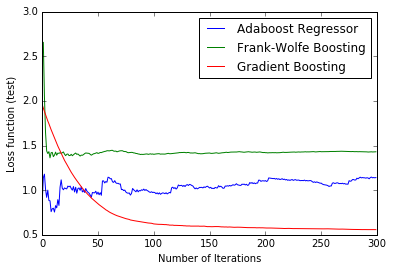

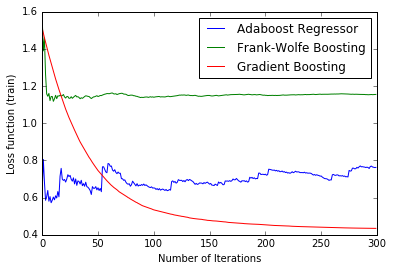

In [14]:
#Compare test error rate vs. number of iterations across algorithms.
plot_clf_series(er_test_0,names,'Number of Iterations','Loss function (test)',0)
#Compare test error rate vs. number of iterations across algorithms.
plot_clf_series(er_train_0,names,'Number of Iterations','Loss function (train)',0)

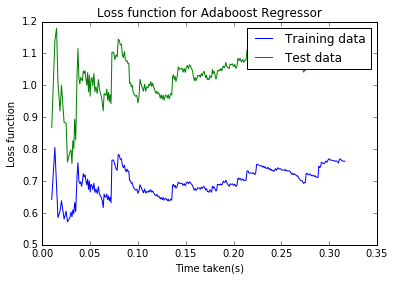

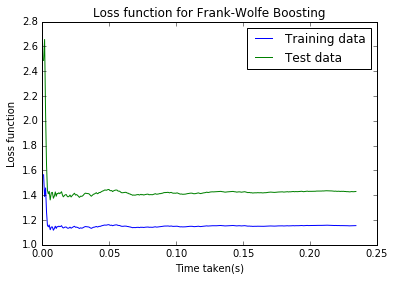

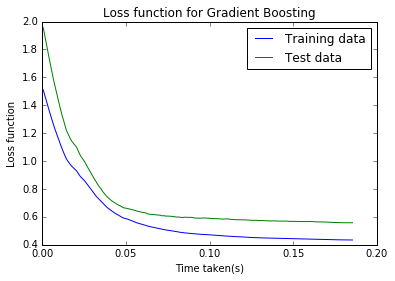

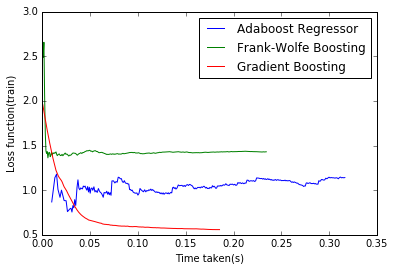

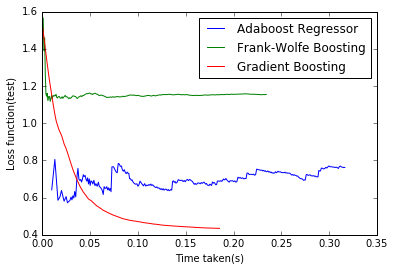

In [15]:
#Do the same w.r.t. the time taken (instead of numer of iterations).
for i in range(NUM_ALGO):
    plot_1_clf(er_train_0[:,i], er_test_0[:,i], 'Time taken(s)', 'Loss function',names[i],0,time_taken_0[:,i])    
    
plot_clf_series(er_test_0,names,'Time taken(s)','Loss function(train)',0,time_taken_0)
#Compare test error rate vs. number of iterations across algorithms.
plot_clf_series(er_train_0,names,'Time taken(s)','Loss function(test)',0,time_taken_0)
    
    
    

Here, we simulate the effect of another kind of overfitting, by changing the number of input features, and keeping the number of iterations the same. All the algorithms are run for 50 iterations. Adaboost reached minimum loss function value when more number of features are given as input. Whereas, in FW, overfitting happends when more features are provided and having 5 input features gives the lowest loss function value. Similarly Gradient boosting does best when number of input features are 5.   

In [16]:
#Seeing the effect of changing the number of featured.
#Set number of iterations.
N = 50
#Set maximum features
M = 8
#Initialize the arrays.
er_train_1 = np.zeros((M,NUM_ALGO))
er_test_1 = np.zeros((M,NUM_ALGO))
#Iterate over the algorithms.
clf_base = LinearRegression()

an = 0 
for i in range(M):
    fnum = 1+i
    pred_train, pred_test, er_train, er_test, time_taken = adaboost_clf(Y_train, X_train, Y_test, X_test, N, fnum, an, clf_base)    
    er_train_1[i,0] = er_train[N-1]
    er_test_1[i,0] = er_test[N-1]
    pred_train,pred_test,er_train,er_test,time_taken = fwboost_1_clf(Y_train, X_train, Y_test, X_test, N, fnum, an, clf_base)
    er_train_1[i,1] = er_train[N-1]
    er_test_1[i,1] = er_test[N-1]
    pred_train,pred_test,er_train,er_test,time_taken = Gradient_boost(Y_train, X_train, Y_test, X_test, N, fnum, an , clf_base)
    er_train_1[i,2] = er_train[N-1]
    er_test_1[i,2] = er_test[N-1]


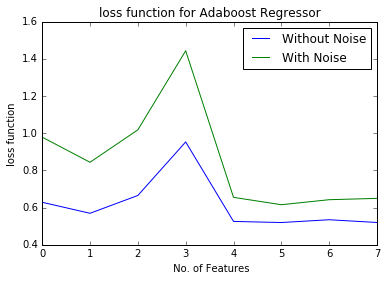

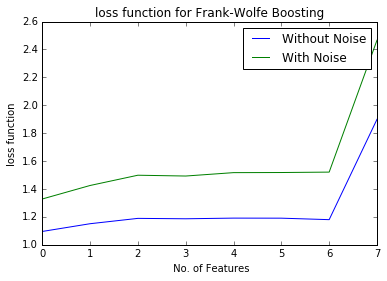

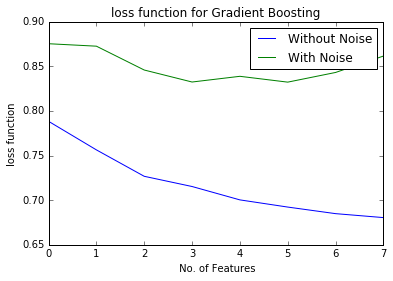

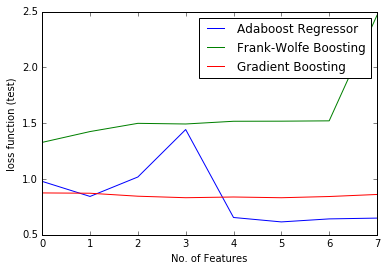

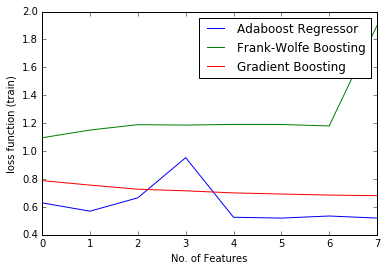

In [17]:
#Do the same w.r.t. the time taken (instead of numer of iterations).
for i in range(NUM_ALGO):
    plot_1_clf(er_train_1[:,i], er_test_1[:,i], ' No. of Features', 'loss function',names[i],1)
#Plot training and test error vs. Number of Features across algorithms.
plot_clf_series(er_test_1,names,'No. of Features','loss function (test)',1)
#Compare test error rate vs. Number of Features  across algorithms.
plot_clf_series(er_train_1,names,'No. of Features','loss function (train)',1)

Here, we simulate the robustness of our algorithms by adding N(mean(Y_train),5) error to the true label (while training) and computing the loss function. From the graphs below, we notice the following:
- As expected, the training and test loss increase for all of the algorithms upon corrupting the labels during training.
- Both Adaboost and FW work poorly when error is added to the data. While FW maintains a constant performance throughout the iterations, Gradient boosting performance becomes significantly worse as the number of iterations increases.
- Due to the above, FWBoost (which performs the worst without any added error), gives the best test & training error among all the algorithms once the label values are corrupted.

In [18]:
# Seeing the effect by adding Gaussian noise to dataset on the number of iterations. 
#Set number of iterations.
N = 300
#Initialize the arrays.
er_train_1 = np.zeros([N,NUM_ALGO])
er_test_1 = np.zeros([N,NUM_ALGO])
time_taken_1 = np.zeros([N,NUM_ALGO])
fnum =2
#Iterate over the algorithms.

#Adaboost
an = 1 #add noise

clf_base = LinearRegression()
pred_train,pred_test,er_train_1[:,0],er_test_1[:,0],time_taken_1[:,0] = adaboost_clf(Y_train, X_train, Y_test, X_test, N, 1, an , clf_base)

# fw boosting
clf_base = LinearRegression()
pred_train,pred_test,er_train_1[:,1],er_test_1[:,1],time_taken_1[:,1] = fwboost_1_clf(Y_train, X_train, Y_test, X_test, N, fnum, an, clf_base)

clf_base = LinearRegression()
pred_train,pred_test,er_train_1[:,2],er_test_1[:,2],time_taken_1[:,2] = Gradient_boost(Y_train, X_train, Y_test, X_test, N, fnum, an, clf_base)



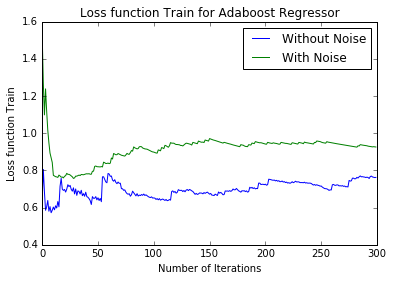

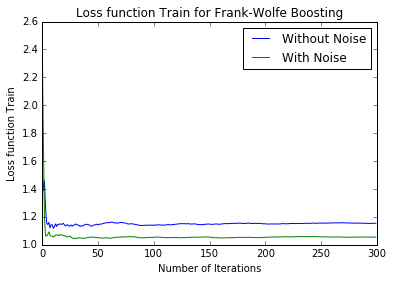

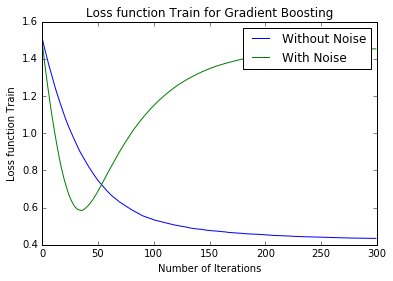

In [19]:
#Plot training and test errors for each algorithm.
for i in range(NUM_ALGO):
    plot_1_clf(er_train_0[:,i], er_train_1[:,i], 'Number of Iterations', 'Loss function Train',names[i],1)

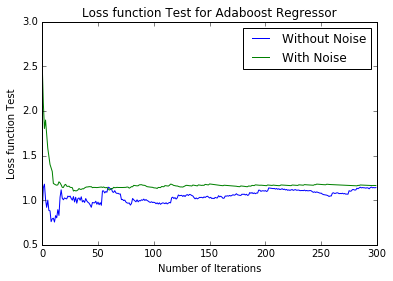

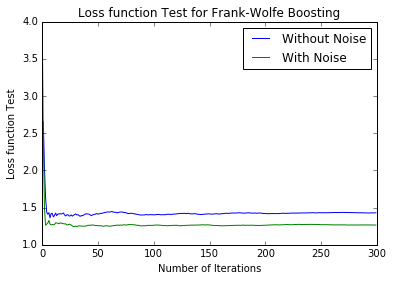

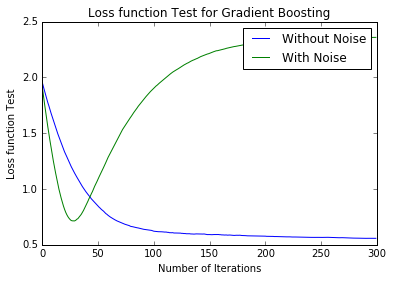

In [20]:
#Plot training and test errors for each algorithm.
for i in range(NUM_ALGO):
    plot_1_clf(er_test_0[:,i], er_test_1[:,i], 'Number of Iterations', 'Loss function Test',names[i],1)